In [66]:
import os, re, copy
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import datetime 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
%matplotlib inline

### Index calculation

In [ ]:
pred_gpt = pd.read_csv(f'../generated/GPT3.5-headlines.csv', index_col=0) 
pred_non = pd.read_csv(f'../generated/Without-sentiment.csv', index_col=0)
pred_fb = pd.read_csv(f'../generated/finBERT-headlines.csv', index_col=0)
pred_llm = pd.read_csv(f'../generated/pred_llama3_70b.csv', index_col=0) 

In [ ]:
mse = mean_squared_error(y_true = pred_llm['Actual'], y_pred = pred_llm['Predicted'])
mae = mean_absolute_error(y_true = pred_llm['Actual'], y_pred = pred_llm['Predicted'])
print(mse**1/2)
print(mae)

0.0020872850033802
0.037797989206230675


In [ ]:
mse = mean_squared_error(y_true = pred_non['Actual'], y_pred = pred_non['Predicted'])
mae = mean_absolute_error(y_true = pred_non['Actual'], y_pred = pred_non['Predicted'])
print(mse**1/2)
print(mae)

0.0020940943753183622
0.037719612199673826


In [ ]:
mse = mean_squared_error(y_true = pred_fb['Actual'], y_pred = pred_fb['Predicted'])
mae = mean_absolute_error(y_true = pred_fb['Actual'], y_pred = pred_fb['Predicted'])
print(mse**1/2)
print(mae)

0.00213337811210026
0.03795255508516404


In [ ]:
mse = mean_squared_error(y_true = pred_gpt['Actual'], y_pred = pred_gpt['Predicted'])
mae = mean_absolute_error(y_true = pred_gpt['Actual'], y_pred = pred_gpt['Predicted'])
print(mse**1/2)
print(mae)

0.0021036465066238946
0.037764451534859765


### Training with walk forward

In [2]:
# predict N days after
PREDICT = 1 #5

WINDOW_SIZE = 30
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.625

torch.manual_seed(1)

Make percentage of return as outcome

In [3]:
df_full = pd.read_csv('../data/df_full.csv', index_col=0)
df_full['Per_ret'] = df_full['Adj Close'].pct_change()
df_full.head()

,Llama-2-7B-GPTQ-fullarticles,Llama-2-70B-GPTQ-headlines,Llama-3-70B-GPTQ-fullarticles,GPT3.5-headlines,Llama-2-70B-GPTQ-fullarticles,finBERT-headlines,Llama-3-8B-GPTQ-fullarticles,Llama-3-70B-GPTQ-headlines,Llama-2-13B-GPTQ-fullarticles,Llama-2-7B-GPTQ-headlines,Llama-2-13b-GGUF-fullarticles,Llama-3-8B-GPTQ-headlines,Llama-2-13B-GPTQ-headlines,Mkt-RF,SMB,HML,RF,Adj Close,Per_ret
Time,,,,,,,,,,,,,,,,,,,
2012-04-20,3.666667,3.333333,4.666667,3.333333,3.333333,2.935755,3.666667,3.333333,3.666667,4.000000,3.666667,3.000000,3.000000,0.11,0.54,-0.10,0.0,68.549644,NaN
2012-04-23,3.333333,3.333333,3.666667,3.666667,3.333333,2.869610,3.333333,3.666667,3.333333,3.333333,3.333333,3.333333,3.333333,-0.95,-0.56,0.15,0.0,67.522797,-0.014980
2012-04-24,3.000000,4.000000,3.000000,4.000000,3.000000,2.634394,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,3.000000,0.29,0.26,0.91,0.0,69.186981,0.024646
2012-04-26,3.000000,3.000000,3.000000,3.000000,3.000000,0.777762,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.75,-0.02,-0.06,0.0,69.470253,0.004094
2012-04-30,3.000000,3.000000,3.000000,3.000000,4.000000,2.604599,3.000000,3.000000,4.000000,3.000000,4.000000,3.000000,3.000000,-0.49,-0.57,0.00,0.0,69.328621,-0.002039


Practice with Llama-3-70B-GPTQ-fullarticles first since this seems to be the prediction with highest quality.

Scale input

In [70]:
df_full = df_full.iloc[1:]

def input_processing(data_name=None):
    if data_name:
        df_x = df_full[[data_name, 'Mkt-RF', 'SMB', 'HML', 'RF', 'Per_ret']].values ## Including outcome in df_x
    else:
        df_x = df_full[['Mkt-RF', 'SMB', 'HML', 'RF', 'Per_ret']].values ## Including outcome in df_x
    
    df_y = df_full.iloc[:, -1].values
    
    # scale the features
    X_scaler = StandardScaler()
    X_scaler.fit(df_x)
    X_scaled = X_scaler.transform(df_x)

    # scale the output
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler.fit(df_y.reshape(len(df_y), 1))
    y_scaled = y_scaler.transform(df_y.reshape(len(df_y), 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

#### Model and Dataset class

In [6]:
class MultivariateTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length, -1]  # Predicting the last variable as an example
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [38]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out


In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Training loop

Example
https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [96]:
def train_model(model, train_data, valid_data, criterion, optimizer, patience, epochs=100):
    # Tracking losses
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    # Initialize the early stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs+1):
        # Training
        model.train() # Should inside epoch loop
        # for batch in zip(train_data[0], train_data[1]):
        seq, labels = train_data
        optimizer.zero_grad()
        y_pred = model(torch.tensor(seq).float())
        # print('Check y_pred labels', y_pred.shape, labels.shape)
        single_loss = criterion(y_pred, torch.tensor(labels).float())
        single_loss.backward()
        optimizer.step()
        train_losses.append(single_loss.item())
            
        # Validating
        model.eval()
        # for batch in zip(valid_data[0], valid_data[1]):
        seq, labels = valid_data
        y_pred = model(torch.tensor(seq).float())
        single_loss = criterion(y_pred, torch.tensor(labels).float())
        valid_losses.append(single_loss.item())
            
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

Refer multivariate example: https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [89]:
def walk_forward_inp_gen(data, X, y, n_train=500, n_test=50):
    X_batch, y_batch = [], []


    for i in range(0, len(y) - n_train, n_test):

        end_ix = i + n_train
        out_end_ix = end_ix + n_test - 1 # Zero purge?
        if out_end_ix > len(X): break
        seq_x, seq_y = X[i:end_ix], y[end_ix-1:out_end_ix, -1]
    
        X_batch.append(seq_x), y_batch.append(seq_y)
    X_batch = np.stack(X_batch, axis = 0)
    y_batch = np.stack(y_batch, axis = 0)
        
    return X_batch, y_batch 

In [90]:
X_scaled, y_scaled, y_scaler = input_processing('Llama-3-70B-GPTQ-fullarticles')
X_batch, y_batch = walk_forward_inp_gen(df_full, X_scaled, y_scaled) 

print(X_batch.shape, y_batch.shape)

(48, 500, 6) (48, 50)


In [91]:
train_loader = X_batch[:-10], y_batch[:-10]
val_loader = X_batch[-10:-5], y_batch[-10:-5]
test_loader = X_batch[-5:], y_batch[-5:]

print(train_loader[0].shape, val_loader[0].shape, test_loader[0].shape)

(38, 500, 6) (5, 500, 6) (5, 500, 6)


In [98]:
input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

model = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
patience = 20

model, avg_train_losses, avg_valid_losses = train_model(model, train_loader, val_loader, criterion, optimizer, patience)

/Users/moadata/miniforge3/envs/trnshgg/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[  1/100] train_loss: 0.19349 valid_loss: 0.17042
Validation loss decreased (inf --> 0.170421).  Saving model ...
[  2/100] train_loss: 0.17016 valid_loss: 0.14912
Validation loss decreased (0.170421 --> 0.149122).  Saving model ...
[  3/100] train_loss: 0.14871 valid_loss: 0.12969
Validation loss decreased (0.149122 --> 0.129692).  Saving model ...
[  4/100] train_loss: 0.12915 valid_loss: 0.11212
Validation loss decreased (0.129692 --> 0.112125).  Saving model ...
[  5/100] train_loss: 0.11147 valid_loss: 0.09638
Validation loss decreased (0.112125 --> 0.096378).  Saving model ...
[  6/100] train_loss: 0.09563 valid_loss: 0.08239
Validation loss decreased (0.096378 --> 0.082389).  Saving model ...
[  7/100] train_loss: 0.08156 valid_loss: 0.07007
Validation loss decreased (0.082389 --> 0.070067).  Saving model ...
[  8/100] train_loss: 0.06918 valid_loss: 0.05931
Validation loss decreased (0.070067 --> 0.059306).  Saving model ...
[  9/100] train_loss: 0.05836 valid_loss: 0.04999
Val

Prediction - medium example

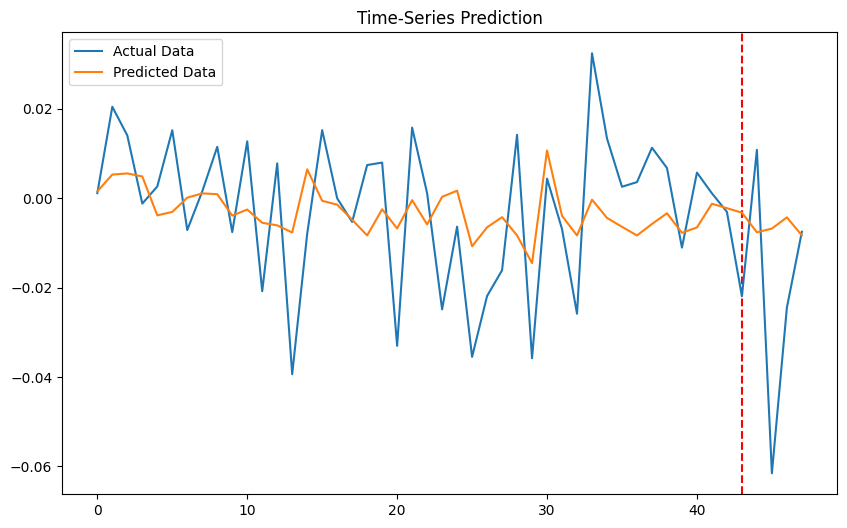

In [102]:
# df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
# df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# # split the sequence
# df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
df_X_ss = X_batch
df_y_mm = y_batch
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss).float()
df_y_mm = torch.Tensor(df_y_mm).float()
# reshaping the dataset
# df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = model(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = y_scaler.inverse_transform(data_predict) # reverse transformation
dataY_plot = y_scaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
train_test_cutoff = 48-5
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show() 

In [110]:
X_test_tensors_final = torch.tensor(test_loader[0]).float()
test_predict = model(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = y_scaler.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

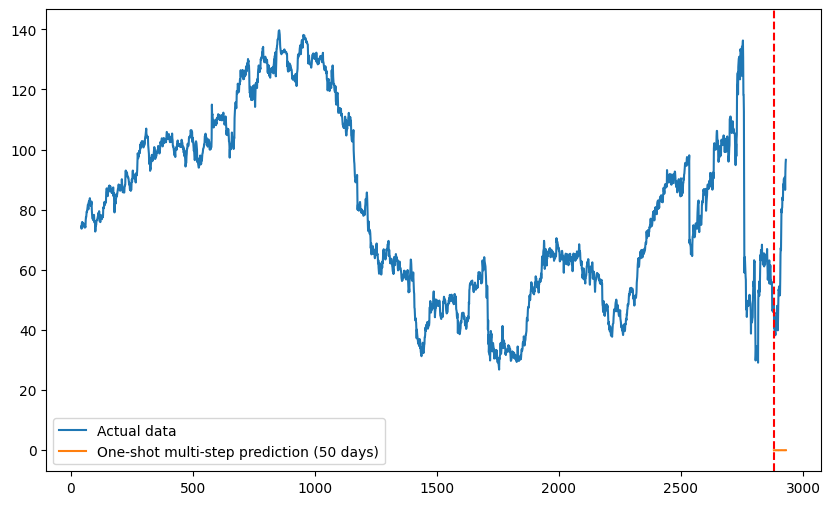

In [111]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(48-5, len(y))]
plt.plot(a, y[48-5:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (50 days)')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()